In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math 
import random
from sklearn.model_selection import train_test_split 

import MDAnalysis as mda
from MDAnalysis.analysis import dihedrals, rms, align
import nglview as nv
import pandas as pd
from tqdm import tqdm
from tensorboardX import SummaryWriter
import os
import time

## Part 1: prepare MD data
#### 1.1. show some information

In [3]:
sys_name = 'AlanineDipeptide'

# name of PDB file
pdb_filename = "MD_samplers/AlanineDipeptideOpenMM/vacuum.pdb"
# name of DCD file
output_path = 'MD_samplers/allegro-data/working_dir/Langevin_working_dir' 
#output_path = './allegro-data/working_dir/Langevin_working_dir-test3-plumed/' 
traj_dcd_filename = '%s/traj.dcd' % output_path

# load the reference configuration from the PDB file
ref = mda.Universe(pdb_filename) 

atoms_info = pd.DataFrame(
    np.array([ref.atoms.ids, ref.atoms.names, ref.atoms.types, ref.atoms.masses, ref.atoms.resids, ref.atoms.resnames]).T, 
    columns=['id', 'name', 'type', 'mass', 'resid', 'resname']
)

# print information of trajectory
print ('\nMD system:\n\
\tno. of atoms: {}\n\
\tno. of residues: {}\n'.format(ref.trajectory.n_atoms, ref.residues.n_residues)
      )
print ('Detailed atom information:\n', atoms_info)

print ('\nSummary:\n', atoms_info['type'].value_counts().rename_axis('type').reset_index(name='counts'))


MD system:
	no. of atoms: 22
	no. of residues: 3

Detailed atom information:
     id  name type    mass resid resname
0    1  1HH3    H   1.008     1     ACE
1    2   CH3    C  12.011     1     ACE
2    3  2HH3    H   1.008     1     ACE
3    4  3HH3    H   1.008     1     ACE
4    5     C    C  12.011     1     ACE
5    6     O    O  15.999     1     ACE
6    7     N    N  14.007     2     ALA
7    8     H    H   1.008     2     ALA
8    9    CA    C  12.011     2     ALA
9   10    HA    H   1.008     2     ALA
10  11    CB    C  12.011     2     ALA
11  12   1HB    H   1.008     2     ALA
12  13   2HB    H   1.008     2     ALA
13  14   3HB    H   1.008     2     ALA
14  15     C    C  12.011     2     ALA
15  16     O    O  15.999     2     ALA
16  17     N    N  14.007     3     NME
17  18     H    H   1.008     3     NME
18  19   CH3    C  12.011     3     NME
19  20  1HH3    H   1.008     3     NME
20  21  2HH3    H   1.008     3     NME
21  22  3HH3    H   1.008     3     NME



/home/wei/miniconda3/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


#### 1.2 load trajectory, and align with respect to refenrence

In [66]:
# define a class for aligning trajectory
class Align(object):
    def __init__(self, ref_pos, align_atom_indices):
        self.atom_indices = align_atom_indices
        self.ref_x = torch.from_numpy(ref_pos[align_atom_indices]).double()        
        # shift reference state 
        ref_c = torch.mean(self.ref_x, 0) 
        self.ref_x = self.ref_x - ref_c
        self.num_atoms = len(align_atom_indices) * 3
        
    def show_info(self):
        print (f'\nAlignment:\n indices of {len(self.atom_indices)} Atoms used in alignment:\n\t', self.atom_indices)
        print ('\n\treference state used in aligment:\n', self.ref_x.numpy())
        
    def dist_to_ref(self, traj):
        return torch.linalg.norm(torch.sub(traj[:,self.atom_indices,:], self.ref_x), dim=(1,2)).numpy()     
            
    def __call__(self, traj):  
        """
        align trajectory by translation and rotation
        """
                         
        traj_selected_atoms = traj[:, self.atom_indices, :]
        # centers
        x_c = torch.mean(traj_selected_atoms, 1, True)
        # translation
        x_notran = traj_selected_atoms - x_c 
        
        xtmp = x_notran.permute((0,2,1))
        prod = torch.matmul(xtmp, self.ref_x) # dimension: traj_length x 3 x 3
        u, s, vh = torch.linalg.svd(prod)

        diag_mat = torch.diag(torch.ones(3)).double().unsqueeze(0).repeat(traj.size(0), 1, 1)

        sign_vec = torch.sign(torch.linalg.det(torch.matmul(u, vh))).detach()
        diag_mat[:,2,2] = sign_vec

        rotate_mat = torch.bmm(torch.bmm(u, diag_mat), vh)

        aligned_traj = torch.matmul(traj-x_c, rotate_mat) 
                
        return aligned_traj     

class Preprocessing(torch.nn.Module):
    
    def __init__(self, ref_pos, align_atom_indices, nn_atom_indices):

        super(Preprocessing, self).__init__()
        
        self.align_atom_indices = torch.tensor(align_atom_indices).long()
        self.ref_x = torch.from_numpy(ref_pos[align_atom_indices]).double()        
        # shift reference state 
        ref_c = torch.mean(self.ref_x, 0) 
        self.ref_x = self.ref_x - ref_c
        self.nn_atom_indices = torch.tensor(nn_atom_indices).long()
        
    def show_info(self):
        print ('atom indices used for alignment: ', self.align_atom_indices.numpy())
        print ('atom indices used for input layer: ', self.nn_atom_indices.numpy())
        print ('\n\treference state used in aligment:\n', self.ref_x.numpy())

    def align(self, traj):  
        """
        align trajectory by translation and rotation
        """
                         
        traj_selected_atoms = traj[:, self.align_atom_indices, :]
        # centers
        x_c = torch.mean(traj_selected_atoms, 1, True)
        # translation
        x_notran = traj_selected_atoms - x_c 
        
        xtmp = x_notran.permute((0,2,1))
        prod = torch.matmul(xtmp, self.ref_x) # dimension: traj_length x 3 x 3
        u, s, vh = torch.linalg.svd(prod)

        diag_mat = torch.diag(torch.ones(3)).double().unsqueeze(0).repeat(traj.size(0), 1, 1)

        sign_vec = torch.sign(torch.linalg.det(torch.matmul(u, vh))).detach()
        diag_mat[:,2,2] = sign_vec

        rotate_mat = torch.bmm(torch.bmm(u, diag_mat), vh)

        aligned_traj = torch.matmul(traj-x_c, rotate_mat) 
                
        return aligned_traj     
    
   
    def forward(self, inp):
        inp = self.align(inp)
        inp = torch.flatten(inp[:,self.nn_atom_indices,:], start_dim=1)
        return inp
    
# load the trajectory data from DCD file
u = mda.Universe(pdb_filename, traj_dcd_filename)

print ('\n[Task 1/2] load trajectory to numpy array...', end='')
# load trajectory to torch tensor 
trajectory = torch.from_numpy(u.trajectory.timeseries(order='fac')).double()
print ('done.')

# print information of trajectory
print ('\nTrajectory Info:\n\
\tno. of frames in trajectory data: {}\n\
\ttimestep: {:.1f}ps\n\
\ttime length: {:.1f}ps\n\
\tshape of trajectory data array: {}'.format(u.trajectory.n_frames, 
                                  u.trajectory.time, 
                                  u.trajectory.totaltime,
                                  trajectory.shape
                                 )
      )

align_selector = "type C or type O or type N"
selected_ids = u.select_atoms(align_selector).ids

print ('\n[Task 2/2] Preprocessing.\naligning by atoms:')
print (atoms_info.loc[atoms_info['id'].isin(selected_ids)][['id','name', 'type']])

train_atom_selector = "type C or type O or type N"
train_atom_ids = u.select_atoms(align_selector).ids 
train_atom_indices = train_atom_ids - 1 # minus one, such that the index starts from 0

#preprocessing the trajectory data
preprocessing_layer = Preprocessing(ref.atoms.positions, selected_ids-1, train_atom_indices)
traj = preprocessing_layer(trajectory)

#input dimension of nn
input_dim = 3 * len(train_atom_ids)
print ('\n{} Atoms used in define neural network:\n'.format(len(train_atom_ids)), atoms_info.loc[atoms_info['id'].isin(train_atom_ids)][['id','name', 'type']])

# print information of trajectory
print ('\nshape of preprocessed trajectory data array:\n {}'.format(traj.shape))
print ('\n[Task 2/2] done.')


/home/wei/miniconda3/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "



[Task 1/2] load trajectory to numpy array...done.

Trajectory Info:
	no. of frames in trajectory data: 50000
	timestep: 1.0ps
	time length: 49999.0ps
	shape of trajectory data array: torch.Size([50000, 22, 3])

[Task 2/2] Preprocessing.
aligning by atoms:
    id name type
1    2  CH3    C
4    5    C    C
5    6    O    O
6    7    N    N
8    9   CA    C
10  11   CB    C
14  15    C    C
15  16    O    O
16  17    N    N
18  19  CH3    C

10 Atoms used in define neural network:
     id name type
1    2  CH3    C
4    5    C    C
5    6    O    O
6    7    N    N
8    9   CA    C
10  11   CB    C
14  15    C    C
15  16    O    O
16  17    N    N
18  19  CH3    C

shape of preprocessed trajectory data array:
 torch.Size([50000, 30])

[Task 2/2] done.


#### (optional) display information

NGLWidget(max_frame=49999)

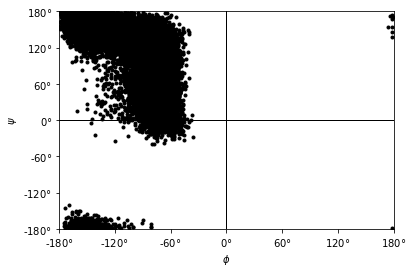

In [24]:
#generate Ramachandran plot of two dihedral angles
ax = plt.axes()
r = dihedrals.Ramachandran(u.select_atoms('resid 2')).run()
r.plot(ax, color='black', marker='.') #, ref=True)

# display the trajectory
view = nv.show_mdanalysis(u)
view   

## Part 2: Training

#### define neural network model and training function

In [67]:
#Auto encoders class and functions for training.
def create_sequential_nn(layer_dims, activation=torch.nn.Tanh()):
    layers = []
    for i in range(len(layer_dims)-2) :
        layers.append(torch.nn.Linear(layer_dims[i], layer_dims[i+1])) 
        layers.append(activation)
    layers.append(torch.nn.Linear(layer_dims[-2], layer_dims[-1])) 
    
    return torch.nn.Sequential(*layers).double()
         
# Next, we define the training function 
def train(model, optimizer, writer, traj, weights, train_atom_indices, num_epochs=10, batch_size=32, test_ratio=0.2):
    """Function to train an AE model
    
    :param model: Neural network model built with PyTorch,
    :param optimizer: PyTorch optimizer object
    :param writer: SummaryWriter for log
    :param traj: torch tensor, trajectory data, shape = (traj. length, no. of atom, 3)
    :param weights: np.array, weights of each point of the trajectory when the dynamics is biased, ndim == 1
    :param num_epochs: int, number of times the training goes through the whole dataset
    :param batch_size: int, number of data points per batch for estimation of the gradient
    :param test_size: float, between 0 and 1, giving the proportion of points used to compute test loss

    :return: model, trained neural net model
    :return: loss_list, list of lists of train losses and test losses; one per batch per epoch
    """
    #--- prepare the data ---
    # split the dataset into a training set (and its associated weights) and a test set
    X_train, X_test, w_train, w_test = train_test_split(traj, weights, test_size=test_ratio)  
    # intialization of the methods to sample with replacement from the data points (needed since weights are present)
    train_sampler = torch.utils.data.WeightedRandomSampler(w_train, len(w_train))
    test_sampler  = torch.utils.data.WeightedRandomSampler(w_test, len(w_test))
    # method to construct data batches and iterate over them
    train_loader = torch.utils.data.DataLoader(dataset=X_train,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=train_sampler)
    test_loader  = torch.utils.data.DataLoader(dataset=X_test,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=test_sampler)
    
    loss_func = torch.nn.MSELoss()
    # --- start the training over the required number of epochs ---
    loss_list = []
    print ("\ntraining starts, %d epochs in total." % num_epochs) 
    for epoch in tqdm(range(num_epochs)):
        # Train the model by going through the whole dataset
        model.train()
        train_loss = []
        for iteration, X in enumerate(train_loader):
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            # Forward pass to get output
            out = model(X)
            # Evaluate loss
            loss = loss_func(out, X)
            # Get gradient with respect to parameters of the model
            loss.backward()
            # Store loss
            train_loss.append(loss)
            # Updating parameters
            optimizer.step()
        # Evaluate the test loss on the test dataset
        model.eval()
        with torch.no_grad():
            # Evaluation of test loss
            test_loss = []
            for iteration, X in enumerate(test_loader):
                out = model(X)
                # Evaluate loss
                loss = loss_func(out,X)
                # Store loss
                test_loss.append(loss)
            loss_list.append([torch.tensor(train_loss), torch.tensor(test_loss)])
            
        writer.add_scalar('Loss/train', torch.mean(torch.tensor(train_loss)), epoch)
        writer.add_scalar('Loss/test', torch.mean(torch.tensor(test_loss)), epoch)
                        
    print ("training ends.\n") 
    
    return model, loss_list

#### set training parameters 

In [86]:
def set_seed_all(seed=-1):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

#All the parameters are set in the cell below. 
seed = None 
if seed:
    set_seed_all(seed)
  
#set training parameters
batch_size = 10000
num_epochs = 10
learning_rate = 0.005
optimizer_algo = 'Adam'  # Adam by default, otherwise SGD

# encoded dimension
k = 1
e_layer_dims = [input_dim, 20, 20, k]
d_layer_dims = [k, 20, 20, input_dim]
print ('\nInput dim: {},\tencoded dim: {}\n'.format(input_dim, k))

activation = torch.nn.Tanh()
encoder = create_sequential_nn(e_layer_dims, activation)
decoder = create_sequential_nn(d_layer_dims, activation)
ae_model = torch.nn.Sequential(encoder, decoder) 

print ('Autoencoder:\n', ae_model)

load_model_filename = 'checkpoint/AlanineDipeptide-2022-02-18-23:41:05/trained_model.pt' #None #'checkpoint/AlanineDipeptide-2022-02-18-13:11:19/trained_model.pt' #None 
    
if load_model_filename is not None:
    ae_model.load_state_dict(torch.load(load_model_filename))
    print (f'model parameters loaded from: {load_model_filename}')
    
# path to store log data
model_save_dir = 'checkpoint'
prefix = f"{sys_name}-" 
model_path = os.path.join(model_save_dir, prefix + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))
print ('\nLog directory: {}\n'.format(model_path))
writer = SummaryWriter(model_path)



Input dim: 30,	encoded dim: 1

Autoencoder:
 Sequential(
  (0): Sequential(
    (0): Linear(in_features=30, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=30, bias=True)
  )
)
model parameters loaded from: checkpoint/AlanineDipeptide-2022-02-18-23:41:05/trained_model.pt

Log directory: checkpoint/AlanineDipeptide-2022-02-18-23:41:59



#### start training 

In [87]:
# Define the optimizer
if optimizer_algo == 'Adam':
    optimizer = torch.optim.Adam(ae_model.parameters(), lr=learning_rate)
else:
    optimizer = torch.optim.SGD(ae_model.parameters(), lr=learning_rate)

ae_model, loss_list = train(ae_model, 
                            optimizer, 
                            writer,
                            traj, 
                            np.ones(trajectory.shape[0]), 
                            train_atom_indices,
                            batch_size=batch_size, 
                            num_epochs=num_epochs
                            )

#save the model
trained_model_filename = f'{model_path}/trained_model.pt'
torch.save(ae_model.state_dict(), trained_model_filename)  
print (f'trained model is saved at: {trained_model_filename}\n')

#--- Compute average train per epoch ---
loss_evol1 = []
for i in range(len(loss_list)):
    loss_evol1.append([torch.mean(loss_list[i][0]), torch.mean(loss_list[i][1])])
loss_evol1 = np.array(loss_evol1)


training starts, 10 epochs in total.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]

training ends.

trained model is saved at: checkpoint/AlanineDipeptide-2022-02-18-23:41:59/trained_model.pt



#### (optional) plot the results 

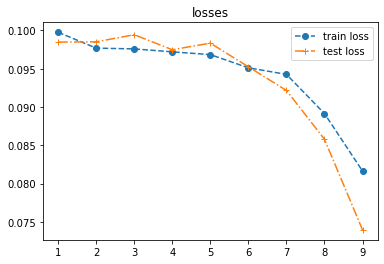

In [88]:
save_fig_to_file = False
start_epoch_index = 1
ax  = plt.axes() 
ax.plot(range(start_epoch_index, num_epochs), loss_evol1[start_epoch_index:, 0], '--', label='train loss', marker='o')
ax.plot(range(1, num_epochs), loss_evol1[start_epoch_index:, 1], '-.', label='test loss', marker='+')
ax.legend()
ax.set_title('losses')

if save_fig_to_file :
    fig_filename = 'training_loss_%s.jpg' % pot_name
    fig.savefig(fig_filename)
    print ('training loss plotted to file: %s' % fig_filename)

#### define CVs using encoder, script, and save to file.

In [89]:
class ColVar(torch.nn.Module):
    def __init__(self, preprocessing_layer, encoder):
        super(ColVar, self).__init__()
        self.preprocessing_layer = preprocessing_layer
        self.encoder = encoder
    def forward(self, inp):
        return self.encoder(self.preprocessing_layer(inp))
    
cv = ColVar(preprocessing_layer, encoder)

trained_script_cv_filename = f'{model_path}/trained_scripted_cv.pt'
torch.jit.script(cv).save(trained_script_cv_filename)

print (f'script model for CVs is saved at:\n\t{trained_script_cv_filename}\n')

script model for CVs is saved at:
	checkpoint/AlanineDipeptide-2022-02-18-23:41:59/trained_scripted_cv.pt



In [90]:
cv = torch.jit.load(trained_script_cv_filename)
print (cv)
print (cv(trajectory))

RecursiveScriptModule(
  original_name=ColVar
  (preprocessing_layer): RecursiveScriptModule(original_name=Preprocessing)
  (encoder): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Tanh)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=Tanh)
    (4): RecursiveScriptModule(original_name=Linear)
  )
)
tensor([[ 2.1566],
        [ 1.7321],
        [ 2.3054],
        ...,
        [-0.0844],
        [-0.0390],
        [-0.1115]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
